In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import random
import os
import matplotlib.colors as mcolors
import random
from rdkit.Chem import AllChem as Chem
from sklearn.decomposition import PCA
from rdkit.Chem import DataStructs
from scipy.stats import pearsonr
%matplotlib inline

In [2]:
plt.rc('axes',labelsize=13)
plt.rc('axes',titlesize=13)

## Figure 1 -- Principle Components of the clustered data

(5521, 2048)
0 592
2 198


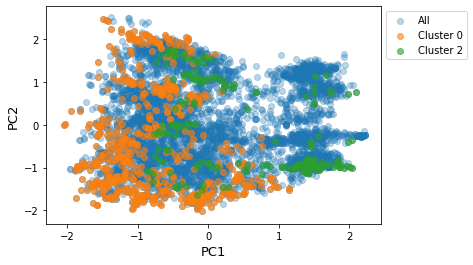

In [4]:
#PC plot for the clusters
#gathering the list of molcules
all_mols=[]
root='data/'
for fname in ['divorced_train0.csv','divorced_test0.csv','divorced_withheld0.csv']:
    df=pd.read_csv(root+fname,header=None)
    smiles=df[0]
    for smi in smiles:
        all_mols.append(Chem.MolFromSmiles(smi))

#getting the training fingerprints
def get_bits(list_o_mols):
    bits=[]
    for mol in list_o_mols:
        fp=Chem.GetMorganFingerprintAsBitVect(mol,2,2048)
        tmp=np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp,tmp)
        bits.append(tmp)
    
    bits=np.array(bits)
    return bits

all_bits=get_bits(all_mols)
print(all_bits.shape)

pca=PCA(n_components=10, svd_solver='randomized',whiten=True)
pca.fit(all_bits)
all_pcs=pca.transform(all_bits)

cluster_defs=pickle.load(open('data/maccs_0.8_pKa_clusters.pkl','rb'))
cluster_tups=[(x,len(x)) for x in cluster_defs]
cluster_tups=sorted(cluster_tups,key=lambda x:x[1],reverse=True)

fig=plt.figure()
plt.scatter(all_pcs[:,0],all_pcs[:,1],alpha=0.3,label='All')
for i, cluster in enumerate(cluster_tups):
    if i==3:
        break
    if i==1:
        continue
    smis=[x[0] for x in cluster[0]]
    mols=[Chem.MolFromSmiles(x) for x in smis]
    new_bits=get_bits(mols)
    new_pcs=pca.transform(new_bits)
    plt.scatter(new_pcs[:,0],new_pcs[:,1],alpha=0.6, label=f'Cluster {i}')
    print(i,cluster[1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.savefig(f'figures/fig1_pca.pdf',bbox_inches='tight')

## Figure 2 -- Initial Results

In [14]:
#gathering the plotting data
#this is clustered Opera split into train/withheld/test
n_added=4367
with open('results/fig2_initial_results.csv','w') as outfile:
    outfile.write('Num Mols Added,Model,Random,RMSE,R\n')
    
    for p in ['mse','dist','evd']:
        if p=='dist':
            m='Gaussian'
        elif p=='evd':
            m='NIG'
        else:
            m='Ensemble'
        
        if p=='evd' or p=='dist':
            for seed in range(5):
                for rand in [False,True]:
                    if rand:
                        fname=f'results/fp_al_50mol_train_divorced/{p}_v2_rand{seed}_seed{seed}.pkl'
                    else:
                        fname=f'results/fp_al_50mol_train_divorced/{p}_v2_seed{seed}.pkl'
                    data=pickle.load(open(fname,'rb'))
                    for n in range(n_added+1):
                        rmse=data[n][0][0]
                        r=data[n][0][1]
                        outfile.write(f'{n},{m},{rand},{rmse},{r}\n')

              
        elif p=='mse':
            #for mse,there are more than 1 thing in each list...
            for seed in range(5):
                for rand in [False,True]:
                    if rand:
                        fname=f'results/fp_al_50mol_train_divorced/{p}_v2_rand{seed}_seed{seed}.pkl'
                    else:
                        fname=f'results/fp_al_50mol_train_divorced/{p}_v2_seed{seed}.pkl'
                    data=pickle.load(open(fname,'rb'))
                    for n in range(n_added+1):
                        rmses=[]
                        rs=[]
                        for rmse_hat, r_hat in data[n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                        outfile.write(f'{n},{m},{rand},{np.mean(rmses)},{np.mean(rs)}\n')

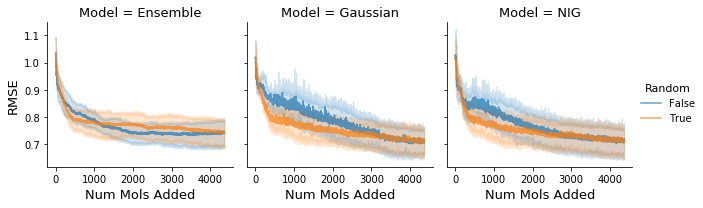

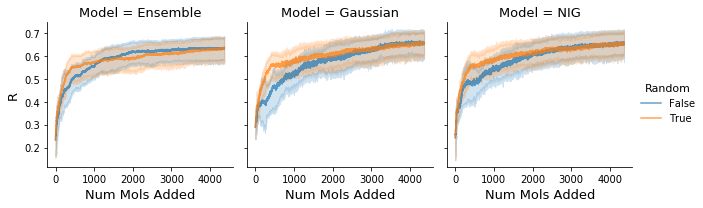

In [15]:
df=pd.read_csv('results/fig2_initial_results.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,col='Model',hue='Random')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig2_initial_results_{yval}.pdf',bbox_inches='tight')

## Figure 3 -- Restricting the data in Fig 2 to largest cluster

In [16]:
#largest cluster -- working within itself only
#gathering the plotting data
n_added=492
with open('results/fig3_largest_cluster.csv','w') as outfile:
    outfile.write('Num Mols Added,Model,Random,RMSE,R\n')
    
    for p in ['mse','dist','evd']:
        if p=='dist':
            m='Gaussian'
        elif p=='evd':
            m='NIG'
        else:
            m='Ensemble'
        
        if p=='evd' or p=='dist':
            for seed in range(5):
                for rand in [False,True]:
                    if rand:
                        fname=f'results/fp_al_50mol_train_divorced/{p}_largest_cluster_rand{seed}_seed{seed}.pkl'
                    else:
                        fname=f'results/fp_al_50mol_train_divorced/{p}_largest_cluster_seed{seed}.pkl'
                    data=pickle.load(open(fname,'rb'))
                    for n in range(n_added+1):
                        rmse=data[n][0][0]
                        r=data[n][0][1]
                        outfile.write(f'{n},{m},{rand},{rmse},{r}\n')

              
        elif p=='mse':
            #for mse,there are more than 1 thing in each list...
            for seed in range(5):
                for rand in [False,True]:
                    if rand:
                        fname=f'results/fp_al_50mol_train_divorced/{p}_largest_cluster_rand{seed}_seed{seed}.pkl'
                    else:
                        fname=f'results/fp_al_50mol_train_divorced/{p}_largest_cluster_seed{seed}.pkl'
                    data=pickle.load(open(fname,'rb'))
                    for n in range(n_added+1):
                        rmses=[]
                        rs=[]
                        for rmse_hat, r_hat in data[n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                        outfile.write(f'{n},{m},{rand},{np.mean(rmses)},{np.mean(rs)}\n')

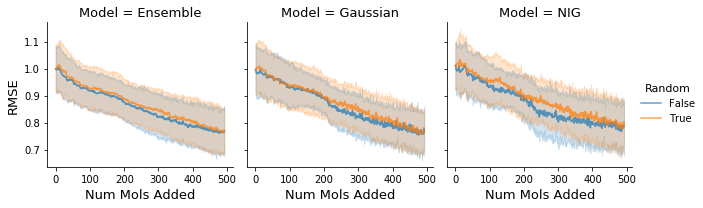

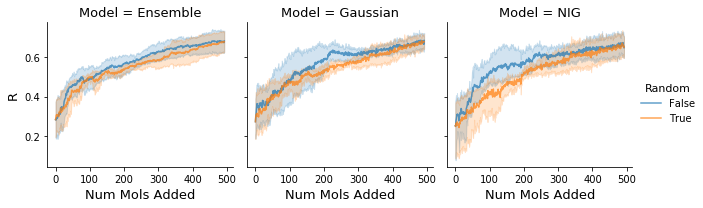

In [17]:
df=pd.read_csv('results/fig3_largest_cluster.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,col='Model',hue='Random')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig3_largest_cluster_{yval}.pdf',bbox_inches='tight')

## Figure 4 -- Verifying Signal exists in the Largest Cluster

In [19]:
#largest cluster fold 0 -- with Greedy results
n_added=492
with open('results/fig4_lc_withgreed.csv','w') as outfile:
    outfile.write('Num Mols Added,Model,Test,Selection,RMSE,R\n')
    
    for p in ['mse','dist','evd']:
        if p=='dist':
            m='Gaussian'
            pickles=glob.glob(f'results/greedy_dist_lc/na*_0_*.pkl')
        elif p=='evd':
            m='NIG'
            pickles=glob.glob(f'results/greedy_evd_lc/na*_0_*.pkl')
        else:
            m='Ensemble'
            pickles=glob.glob(f'results/greedy_mse_lc/na*_0_*.pkl')
        
        for test in ['Test Set','Rest']:
            #first we handle the base case & the random selection
            for rand in [False,True]:
                if rand:
                    fname=f'results/greedy_{p}_lc/{p}_rand0_seed0.pkl'
                    key='Random'
                else:
                    fname=f'results/greedy_{p}_lc/{p}_seed0.pkl'
                    key='Active Learning'
                
                data=pickle.load(open(fname,'rb'))
                for n in range(n_added+1):
                    rmses=[]
                    rs=[]
                    if test=='Rest':
                        for rmse_hat,r_hat in data['test2'][n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                    else:
                        for rmse_hat,r_hat in data[n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                    outfile.write(f'{n},{m},{test},{key},{np.mean(rmses)},{np.mean(rs)}\n')
            #now we add the greedy data
            for fname in pickles:
                data=pickle.load(open(fname,'rb'))
                if test=='Rest':
                    rmses=[x[0] for x in data['test2'][0]]
                    rs=[x[1] for x in data['test2'][0]]
                else:
                    rmses=[x[0] for x in data[0]]
                    rs=[x[1] for x in data[0]]
                n=fname.split('/na')[1].split('_')[0]
                outfile.write(f'{n},{m},{test},Greedy,{np.mean(rmses)},{np.mean(rs)}\n')
                
                if int(n)==n_added-1:
                    if test=='Rest':
                        rmses=[x[0] for x in data['test2'][1]]
                        rs=[x[1] for x in data['test2'][1]]
                    else:
                        rmses=[x[0] for x in data[1]]
                        rs=[x[1] for x in data[1]]
                    
                    outfile.write(f'{int(n)+1},{m},{test},Greedy,{np.mean(rmses)},{np.mean(rs)}\n')

In [23]:
plt.rc('axes',labelsize=11)
plt.rc('axes',titlesize=11)

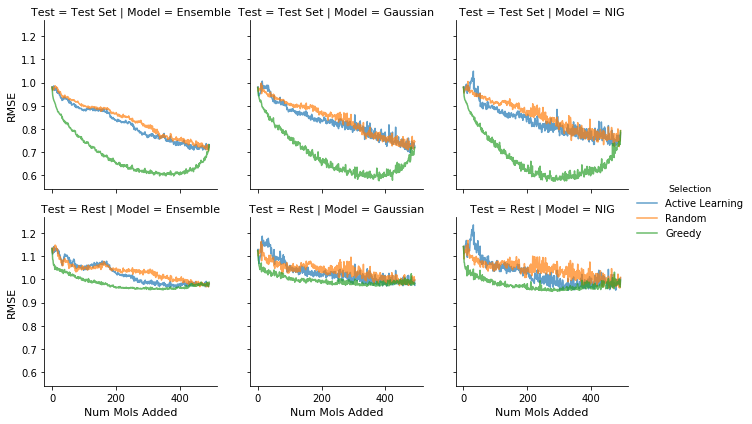

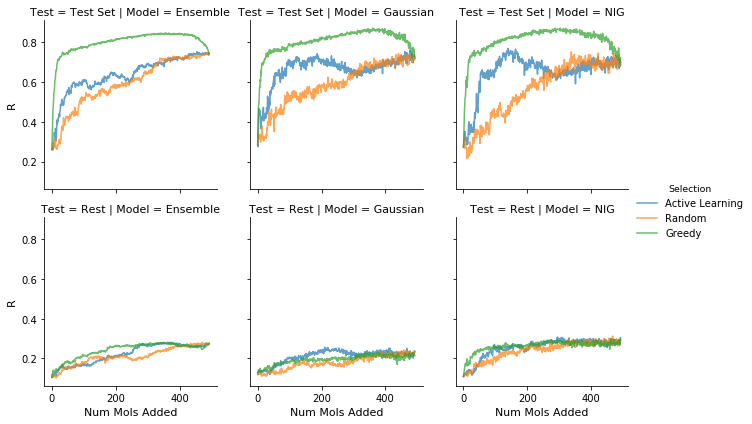

In [24]:
df=pd.read_csv('results/fig4_lc_withgreed.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,col='Model',hue='Selection',row='Test')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig4_lc_withgreed_{yval}.pdf',bbox_inches='tight')

## Figure 4a -- Verifying if Greedy Selection works with Validation set

In [2]:
n_added=442 #moved 50 molecules to validation from withheld
with open('results/fig4a_lc_greed_withvalid.csv','w') as outfile:
    outfile.write('Num Mols Added,Model,Test,Selection,RMSE,R\n')
    
    for p in ['mse','dist','evd']:
        if p=='dist':
            m='Gaussian'
            pickles=glob.glob(f'results/greedy_dist_lc_valid/na*_0_*.pkl')
        elif p=='evd':
            m='NIG'
            pickles=glob.glob(f'results/greedy_evd_lc_valid/na*_0_*.pkl')
        else:
            m='Ensemble'
            pickles=glob.glob(f'results/greedy_mse_lc_valid/na*_0_*.pkl')
        
        for test in ['Validation','Test Set']:
            #first we handle the base case & the random selection
            for rand in [False,True]:
                if rand:
                    fname=f'results/greedy_{p}_lc_valid/{p}_rand0_seed0.pkl'
                    key='Random'
                else:
                    fname=f'results/greedy_{p}_lc_valid/{p}_seed0.pkl'
                    key='Active Learning'
                
                data=pickle.load(open(fname,'rb'))
                for n in range(n_added+1):
                    rmses=[]
                    rs=[]
                    if test=='Test Set':
                        for rmse_hat,r_hat in data['test2'][n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                    else:
                        for rmse_hat,r_hat in data[n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                    outfile.write(f'{n},{m},{test},{key},{np.mean(rmses)},{np.mean(rs)}\n')
            #now we add the greedy data
            for fname in pickles:
                data=pickle.load(open(fname,'rb'))
                if test=='Test Set':
                    rmses=[x[0] for x in data['test2'][0]]
                    rs=[x[1] for x in data['test2'][0]]
                else:
                    rmses=[x[0] for x in data[0]]
                    rs=[x[1] for x in data[0]]
                n=fname.split('/na')[1].split('_')[0]
                outfile.write(f'{n},{m},{test},Greedy,{np.mean(rmses)},{np.mean(rs)}\n')
                
                if int(n)==n_added-1:
                    if test=='Test Set':
                        rmses=[x[0] for x in data['test2'][1]]
                        rs=[x[1] for x in data['test2'][1]]
                    else:
                        rmses=[x[0] for x in data[1]]
                        rs=[x[1] for x in data[1]]
                    
                    outfile.write(f'{int(n)+1},{m},{test},Greedy,{np.mean(rmses)},{np.mean(rs)}\n')

In [11]:
plt.rc('axes',labelsize=10)
plt.rc('axes',titlesize=10)

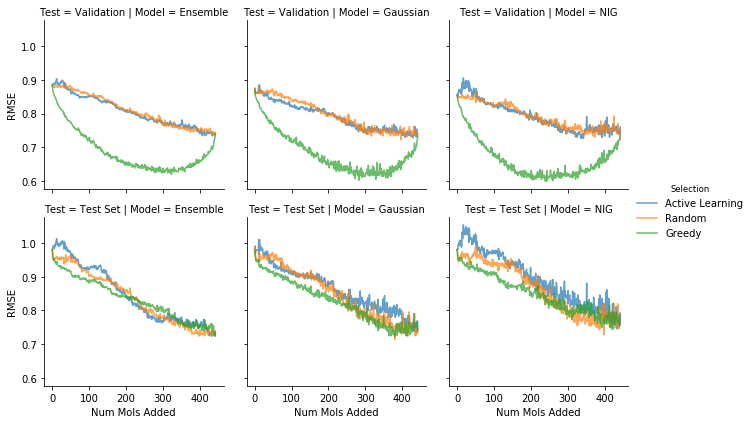

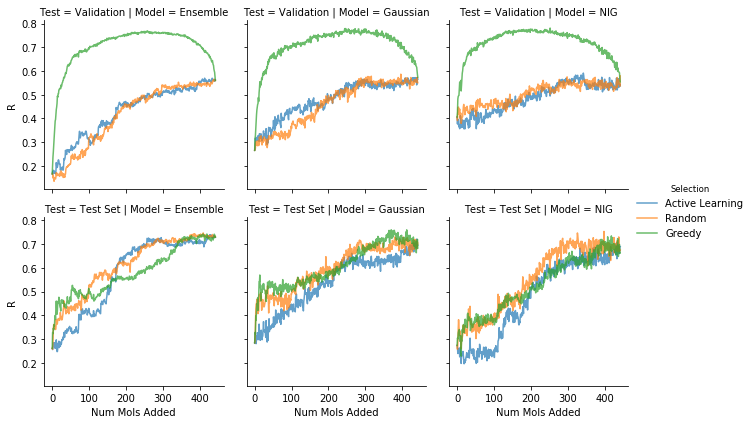

In [12]:
df=pd.read_csv('results/fig4a_lc_greed_withvalid.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,col='Model',hue='Selection',row='Test')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig4a_lc_greed_withvalid_{yval}.pdf',bbox_inches='tight')

## Figure 5 -- Adding a second cluster to improve coverage

In [25]:
plt.rc('axes',labelsize=13)
plt.rc('axes',titlesize=13)

In [26]:
#lc 02 fold 0 -- on self & rest
n_added=690
with open('results/fig5_lc02.csv','w') as outfile:
    outfile.write('Num Mols Added,Model,Test,Selection,RMSE,R\n')
    m='NIG'
    pickles=glob.glob(f'results/greedy_evd_400ep_lc02/na*_0_*.pkl')
    for test in ['Test Set','Rest']:
        #first we handle the base case & the random selection
        for rand in [False,True]:
            if rand:
                fname=f'results/greedy_evd_400ep_lc02/evd_rand0_seed0.pkl'
                key='Random'
            else:
                fname=f'results/greedy_evd_400ep_lc02/evd_seed0.pkl'
                key='Active Learning'

            data=pickle.load(open(fname,'rb'))
            for n in range(n_added+1):
                rmses=[]
                rs=[]
                if test=='Rest':
                    for rmse_hat,r_hat in data['test2'][n]:
                        rmses.append(rmse_hat)
                        rs.append(r_hat)
                else:
                    for rmse_hat,r_hat in data[n]:
                        rmses.append(rmse_hat)
                        rs.append(r_hat)
                outfile.write(f'{n},{m},{test},{key},{np.mean(rmses)},{np.mean(rs)}\n')
        #now we add the greedy data
        for fname in pickles:
            data=pickle.load(open(fname,'rb'))
            if test=='Rest':
                rmses=[x[0] for x in data['test2'][0]]
                rs=[x[1] for x in data['test2'][0]]
            else:
                rmses=[x[0] for x in data[0]]
                rs=[x[1] for x in data[0]]
            n=fname.split('/na')[1].split('_')[0]
            outfile.write(f'{n},{m},{test},Greedy,{np.mean(rmses)},{np.mean(rs)}\n')

            if int(n)==n_added-1:
                if test=='Rest':
                    rmses=[x[0] for x in data['test2'][1]]
                    rs=[x[1] for x in data['test2'][1]]
                else:
                    rmses=[x[0] for x in data[1]]
                    rs=[x[1] for x in data[1]]

                outfile.write(f'{int(n)+1},{m},{test},Greedy,{np.mean(rmses)},{np.mean(rs)}\n')

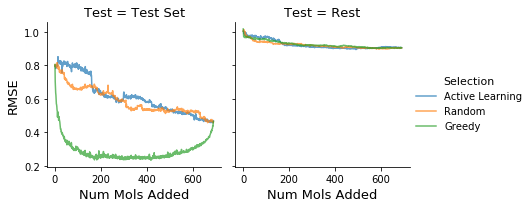

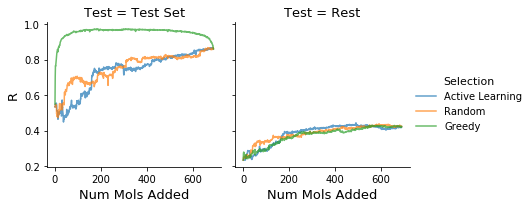

In [27]:
df=pd.read_csv('results/fig5_lc02.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,hue='Selection',col='Test')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig5_lc02_{yval}.pdf',bbox_inches='tight')

## Figure 6 -- Trying a different input representation

In [28]:
#MAT pt transformer
n_added=690
with open('results/fig6_MAT_input.csv','w') as outfile:
    outfile.write('Num Mols Added,Model,Epochs,Test,Selection,RMSE,R\n')
    
    for p in ['evd','dist','mse']:
        if p=='dist':
            m='Gaussian'
        elif p=='evd':
            m='NIG'
        else:
            m='Ensemble'
        
        for epochs in [4,40,400]:
            for test in ['Test Set','Rest']:
                #first we handle the base case & the random selection
                for rand in [False,True]:
                    if rand:
                        fname=f'results/MAT_transformer_lc02/{p}_hd2_1024_{epochs}e_rand0_seed0.pkl'
                        key='Random'
                    else:
                        fname=f'results/MAT_transformer_lc02/{p}_hd2_1024_{epochs}e_seed0.pkl'
                        key='Active Learning'

                    data=pickle.load(open(fname,'rb'))
                    for n in range(n_added+1):
                        rmses=[]
                        rs=[]
                        if test=='Rest':
                            for rmse_hat,r_hat in data['test2'][n]:
                                rmses.append(rmse_hat)
                                rs.append(r_hat)
                        else:
                            for rmse_hat,r_hat in data[n]:
                                rmses.append(rmse_hat)
                                rs.append(r_hat)
                        outfile.write(f'{n},{m},{epochs},{test},{key},{np.mean(rmses)},{np.mean(rs)}\n')

In [30]:
plt.rc('axes',labelsize=11)
plt.rc('axes',titlesize=11)

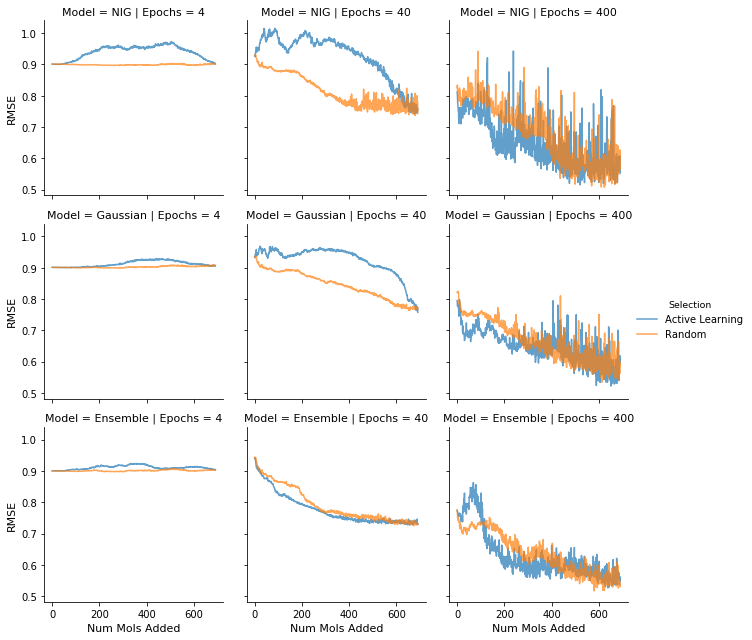

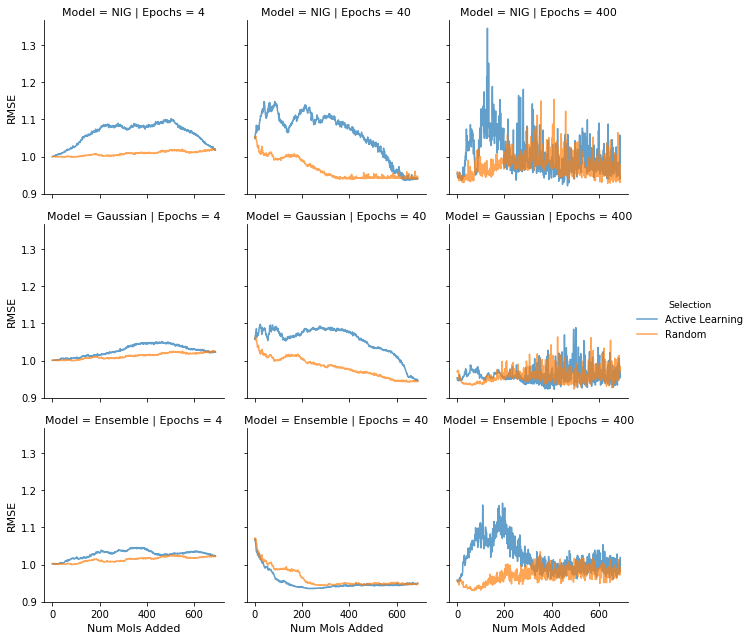

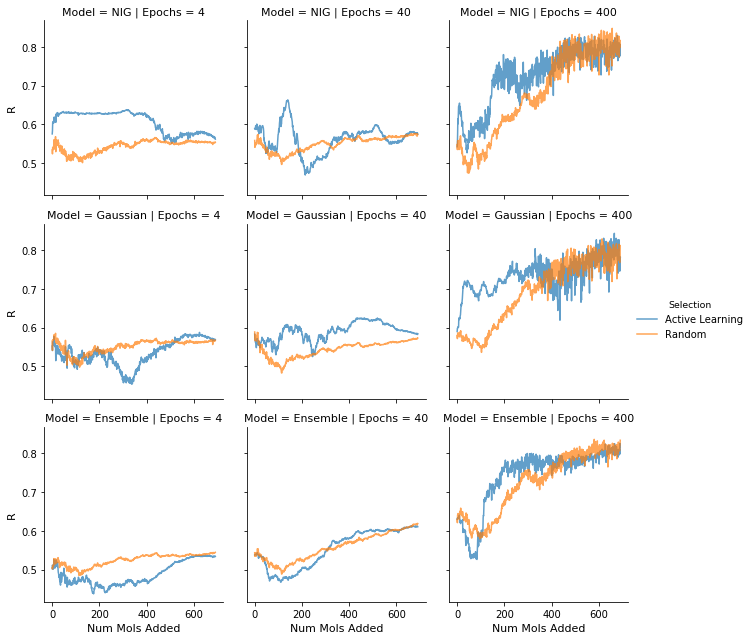

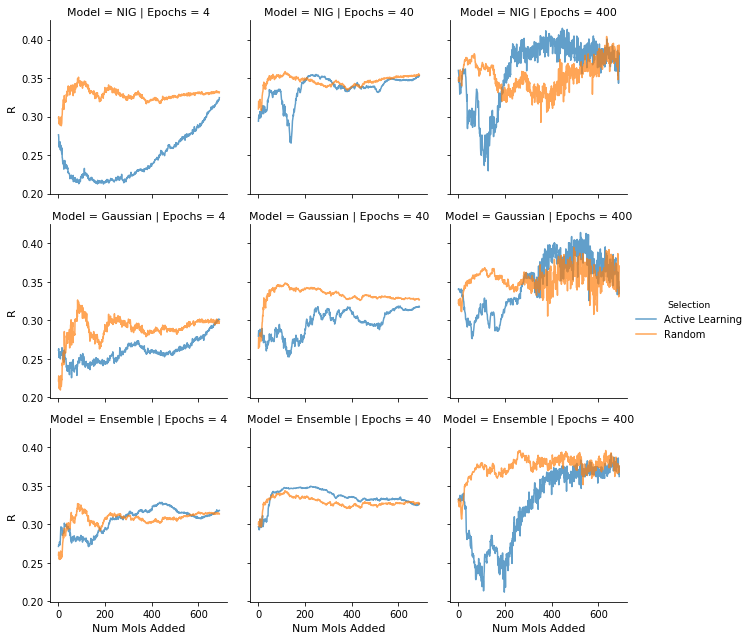

In [31]:
df=pd.read_csv('results/fig6_MAT_input.csv')

for yval in ['RMSE','R']:
    for ts in ['Test Set','Rest']:
        tmp=df[df['Test']==ts]
        g=sns.FacetGrid(tmp,hue='Selection',row='Model',col='Epochs')
        g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
        g.add_legend()
        if ts=='Rest':
            plt.savefig(f'figures/fig6_MAT_input_{yval}_rest.pdf',bbox_inches='tight')
        else:
            plt.savefig(f'figures/fig6_MAT_input_{yval}.pdf',bbox_inches='tight')

## Figure 7 -- verifying the evd MAT input result across 5 seeds

In [32]:
#expanding the other folds of 4epoch MAT model
#gathering the plotting data
n_added=690
with open('results/fig7_expanded_MAT.csv','w') as outfile:
    outfile.write('Num Mols Added,Model,Random,RMSE,R\n')
    
    for p in ['evd']:#,'mse']:
        if p=='dist':
            m='Gaussian'
        elif p=='evd':
            m='NIG'
        else:
            m='Ensemble'
        
        for seed in range(5):
            for rand in [False,True]:
                if rand:
                    fname=f'results/MAT_transformer_lc02/{p}_hd2_1024_4e_rand{seed}_seed{seed}.pkl'
                else:
                    fname=f'results/MAT_transformer_lc02/{p}_hd2_1024_4e_seed{seed}.pkl'
                data=pickle.load(open(fname,'rb'))
                for n in range(n_added+1):
                    rmse=data[n][0][0]
                    r=data[n][0][1]
                    outfile.write(f'{n},{m},{rand},{rmse},{r}\n')

In [33]:
plt.rc('axes',labelsize=13)
plt.rc('axes',titlesize=13)

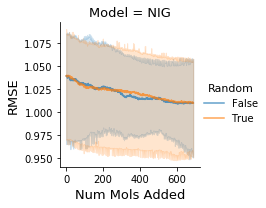

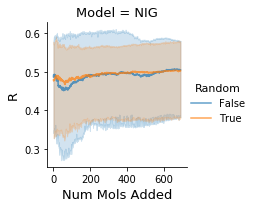

In [37]:
df=pd.read_csv('results/fig7_expanded_MAT.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,col='Model',hue='Random')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig7_expanded_MAT_{yval}.pdf',bbox_inches='tight')

# Figure 8 -- Using a large fingerprint model

In [35]:
n_added=690
with open('results/fig8_morgan_fp_bigmodel.csv','w') as outfile:
    outfile.write('Num Mols Added,Random,Model,Epochs,RMSE,R\n')
    for model in ['evd','dist','mse']:
        if model=='evd':
            label='Evidence'
        elif model=='dist':
            label='Gaussian'
        else:
            label='MSE'
        for epochs in [4,40,400]:
            for split in [0]:#,1,2]:
                #adding the original mse data
                #for mse,there are more than 1 thing in each list...
                for rand in [False,True]:
                    if rand:
                        fname=f'results/nh9_morgan_al/{model}_nh9_{epochs}e_rand0_seed0.pkl'
                    else:
                        fname=f'results/nh9_morgan_al/{model}_nh9_{epochs}e_seed0.pkl'
                    data=pickle.load(open(fname,'rb'))
                    for n in range(n_added+1):
                        rmses=[]
                        rs=[]
                        for rmse_hat, r_hat in data[n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                        if rand:
                            outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')
                        else:
                            outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')

with open('results/fig8_morgan_fp_bigmodel_rest.csv','w') as outfile:
    outfile.write('Num Mols Added,Random,Model,Epochs,RMSE,R\n')
    for model in ['evd','dist','mse']:
        if model=='evd':
            label='Evidence'
        elif model=='dist':
            label='Gaussian'
        else:
            label='MSE'
        for epochs in [4,40,400]:
            for split in [0]:#,1,2]:
                #adding the original mse data
                #for mse,there are more than 1 thing in each list...
                for rand in [False,True]:
                    if rand:
                        fname=f'results/nh9_morgan_al/{model}_nh9_{epochs}e_rand0_seed0.pkl'
                    else:
                        fname=f'results/nh9_morgan_al/{model}_nh9_{epochs}e_seed0.pkl'
                    data=pickle.load(open(fname,'rb'))
                    for n in range(n_added+1):
                        rmses=[]
                        rs=[]
                        for rmse_hat, r_hat in data['test2'][n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                        if rand:
                            outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')
                        else:
                            outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')

In [39]:
plt.rc('axes',labelsize=11)
plt.rc('axes',titlesize=11)

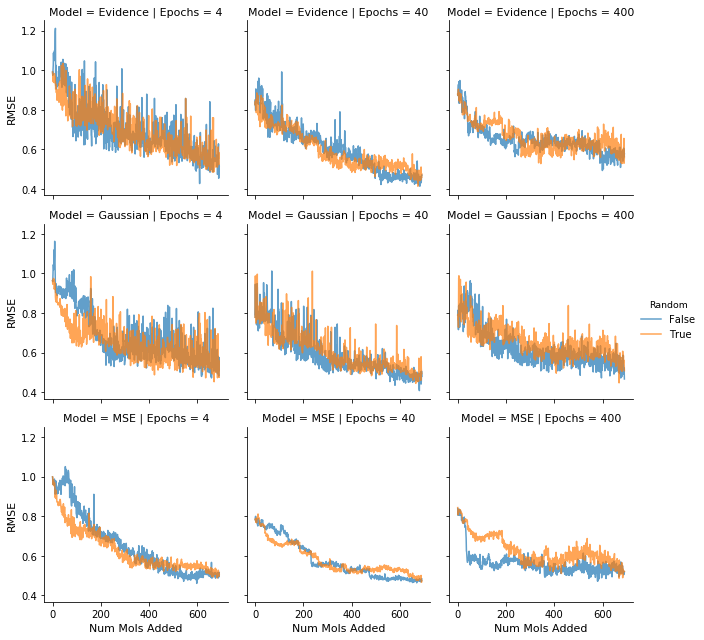

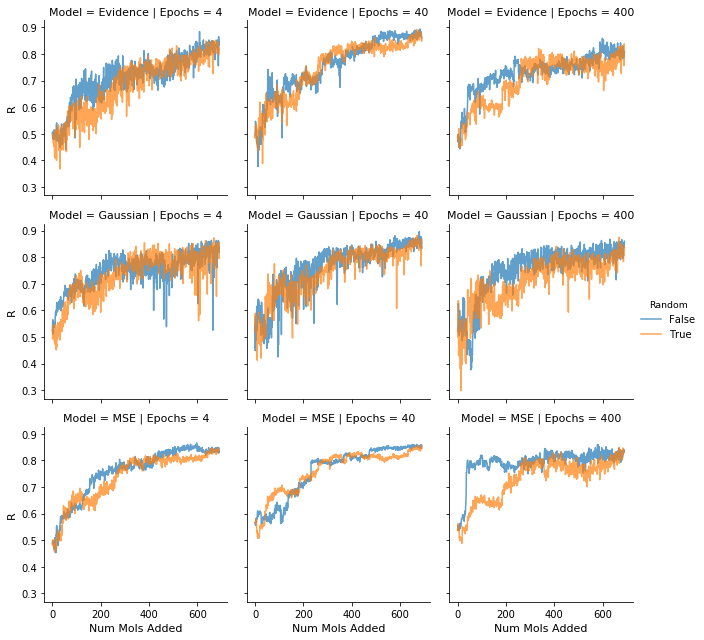

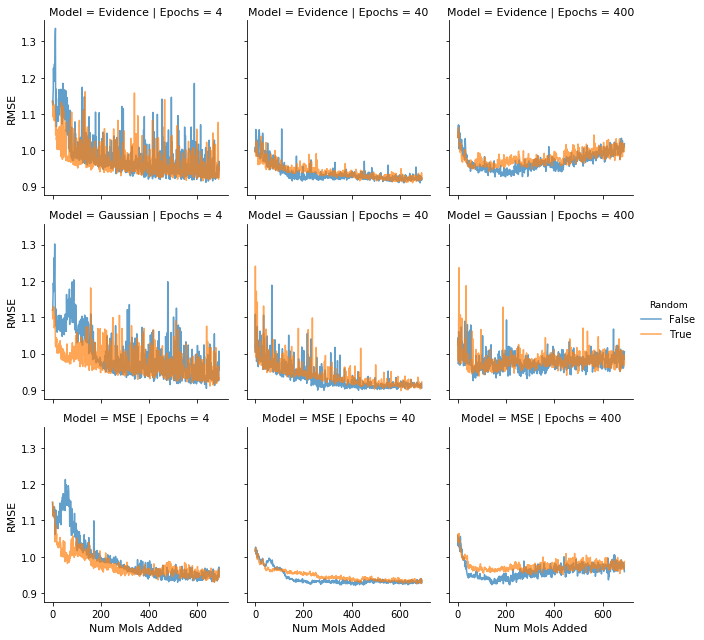

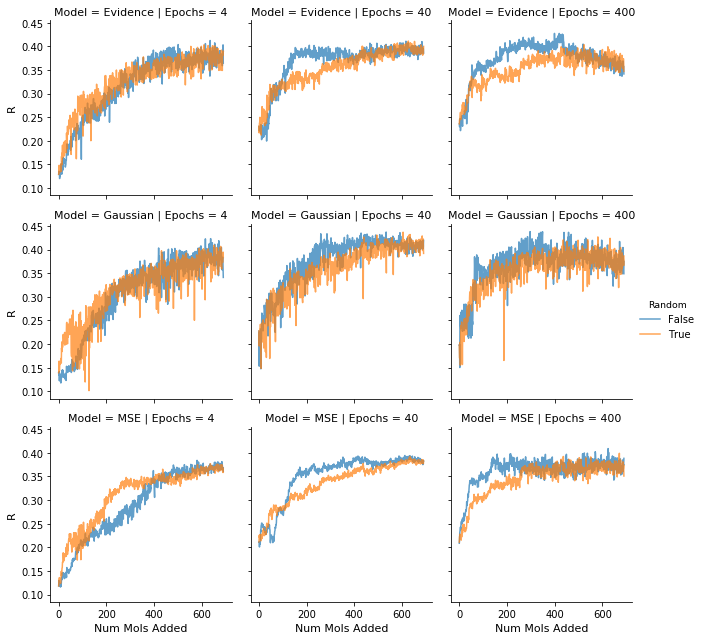

In [40]:
df=pd.read_csv('results/fig8_morgan_fp_bigmodel.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,hue='Random',row='Model',col='Epochs')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig8_morgan_fp_bigmodel_{yval}.pdf',bbox_inches='tight')

df=pd.read_csv('results/fig8_morgan_fp_bigmodel_rest.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,hue='Random',row='Model',col='Epochs')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig8_morgan_fp_bigmodel_rest_{yval}.pdf',bbox_inches='tight')

# Figure 9 -- Looking at active learning by label

In [41]:
n_added=690
with open('results/fig9_morgan_fp_bylabel.csv','w') as outfile:
    outfile.write('Num Mols Added,Random,Model,Epochs,RMSE,R\n')
    for model in ['evd','dist','mse']:
        if model=='evd':
            label='Evidence'
        elif model=='dist':
            label='Gaussian'
        else:
            label='MSE'
        for epochs in [4,40,400]:
            for split in [0]:#,1,2]:
                #adding the original mse data
                #for mse,there are more than 1 thing in each list...
                for rand in [False,True]:
                    if rand:
                        fname=f'results/fp_al_bylabel_lc02/{model}_{epochs}e_rand0_seed0.pkl'
                    else:
                        fname=f'results/fp_al_bylabel_lc02/{model}_{epochs}e_seed0.pkl'
                    data=pickle.load(open(fname,'rb'))
                    for n in range(n_added+1):
                        rmses=[]
                        rs=[]
                        for rmse_hat, r_hat in data[n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                        if rand:
                            outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')
                        else:
                            outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')

with open('results/fig9_morgan_fp_bylabel_rest.csv','w') as outfile:
    outfile.write('Num Mols Added,Random,Model,Epochs,RMSE,R\n')
    for model in ['evd','dist','mse']:
        if model=='evd':
            label='Evidence'
        elif model=='dist':
            label='Gaussian'
        else:
            label='MSE'
        for epochs in [4,40,400]:
            for split in [0]:#,1,2]:
                #adding the original mse data
                #for mse,there are more than 1 thing in each list...
                for rand in [False,True]:
                    if rand:
                        fname=f'results/fp_al_bylabel_lc02/{model}_{epochs}e_rand0_seed0.pkl'
                    else:
                        fname=f'results/fp_al_bylabel_lc02/{model}_{epochs}e_seed0.pkl'
                    data=pickle.load(open(fname,'rb'))
                    for n in range(n_added+1):
                        rmses=[]
                        rs=[]
                        for rmse_hat, r_hat in data['test2'][n]:
                            rmses.append(rmse_hat)
                            rs.append(r_hat)
                        if rand:
                            outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')
                        else:
                            outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')

In [44]:
plt.rc('axes',labelsize=11)
plt.rc('axes',titlesize=11)

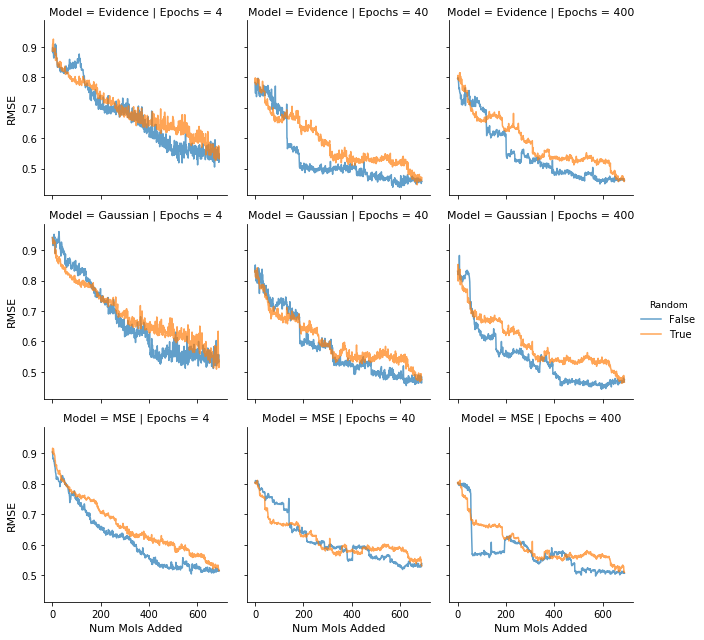

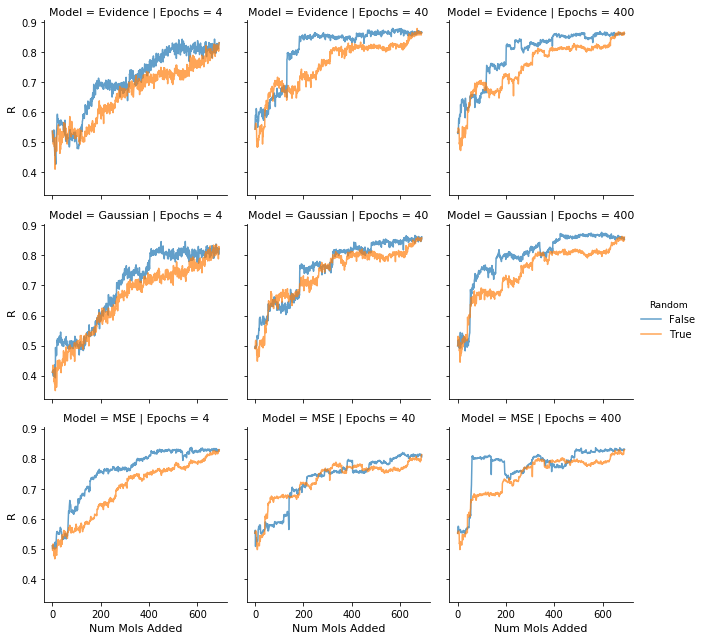

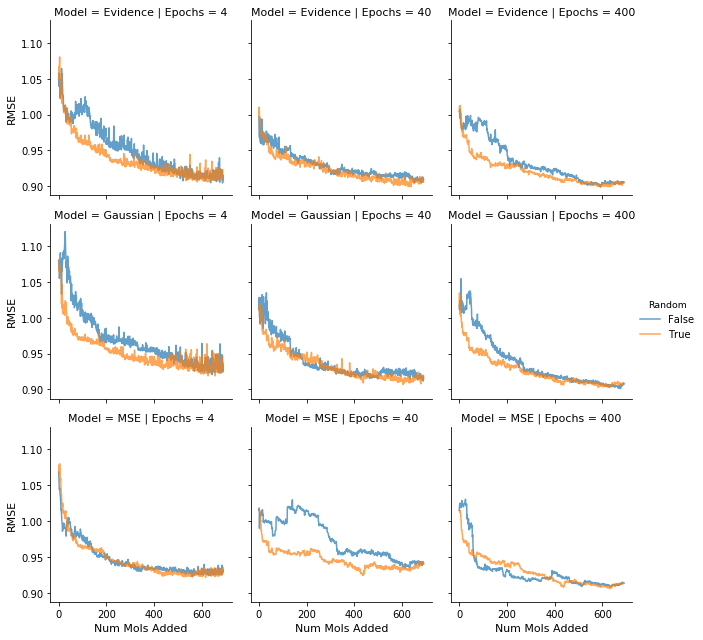

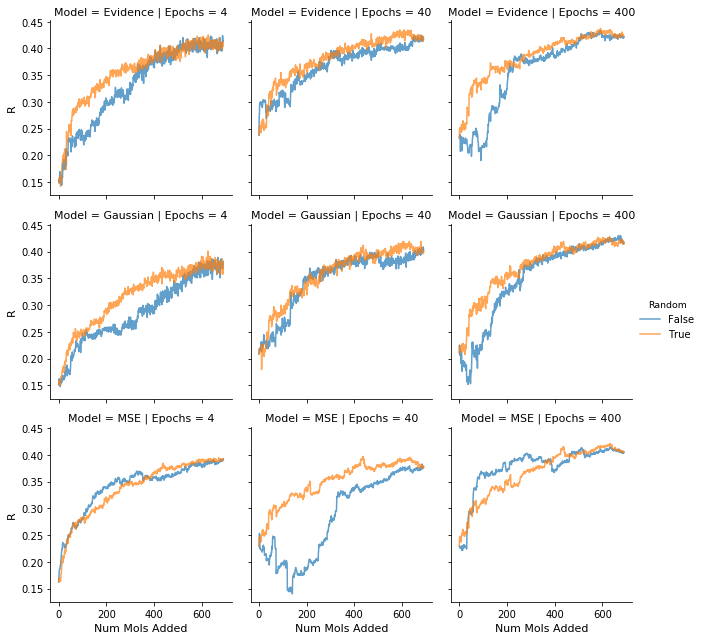

In [45]:
df=pd.read_csv('results/fig9_morgan_fp_bylabel.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,hue='Random',row='Model',col='Epochs')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig9_morgan_fp_bylabel_{yval}.pdf',bbox_inches='tight')

df=pd.read_csv('results/fig9_morgan_fp_bylabel_rest.csv')
for yval in ['RMSE','R']:
    g=sns.FacetGrid(df,hue='Random',row='Model',col='Epochs')
    g.map(sns.lineplot,'Num Mols Added',yval,alpha=0.7)
    g.add_legend()
    plt.savefig(f'figures/fig9_morgan_fp_bylabel_rest_{yval}.pdf',bbox_inches='tight')

## Figure 10 -- Selecting molecules in batches

In [47]:
n_added=69
for key in ['nh9','bylabel']:
    with open(f'results/fig10_morgan_fp_{key}_molbatch.csv','w') as outfile:
        outfile.write('Num Batches Added,Random,Model,Epochs,RMSE,R\n')
        for model in ['evd','dist','mse']:
            if model=='evd':
                label='Evidence'
            elif model=='dist':
                label='Gaussian'
            else:
                label='MSE'
            for epochs in [4,40,400]:
                for split in [0]:#,1,2]:
                    #adding the original mse data
                    #for mse,there are more than 1 thing in each list...
                    for rand in [False,True]:
                        if rand:
                            fname=f'results/batch_10mol_lc02/{model}_{key}_{epochs}e_rand0_seed0.pkl'
                        else:
                            fname=f'results/batch_10mol_lc02/{model}_{key}_{epochs}e_seed0.pkl'
                        data=pickle.load(open(fname,'rb'))
                        for n in range(n_added+1):
                            rmses=[]
                            rs=[]
                            for rmse_hat, r_hat in data[n]:
                                rmses.append(rmse_hat)
                                rs.append(r_hat)
                            if rand:
                                outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')
                            else:
                                outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')

    with open(f'results/fig10_morgan_fp_{key}_molbatch_rest.csv','w') as outfile:
        outfile.write('Num Batches Added,Random,Model,Epochs,RMSE,R\n')
        for model in ['evd','dist','mse']:
            if model=='evd':
                label='Evidence'
            elif model=='dist':
                label='Gaussian'
            else:
                label='MSE'
            for epochs in [4,40,400]:
                for split in [0]:#,1,2]:
                    #adding the original mse data
                    #for mse,there are more than 1 thing in each list...
                    for rand in [False,True]:
                        if rand:
                            fname=f'results/batch_10mol_lc02/{model}_{key}_{epochs}e_rand0_seed0.pkl'
                        else:
                            fname=f'results/batch_10mol_lc02/{model}_{key}_{epochs}e_seed0.pkl'
                        data=pickle.load(open(fname,'rb'))
                        for n in range(n_added+1):
                            rmses=[]
                            rs=[]
                            for rmse_hat, r_hat in data['test2'][n]:
                                rmses.append(rmse_hat)
                                rs.append(r_hat)
                            if rand:
                                outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')
                            else:
                                outfile.write(f'{n},{rand},{label},{epochs},{np.mean(rmses)},{np.mean(rs)}\n')

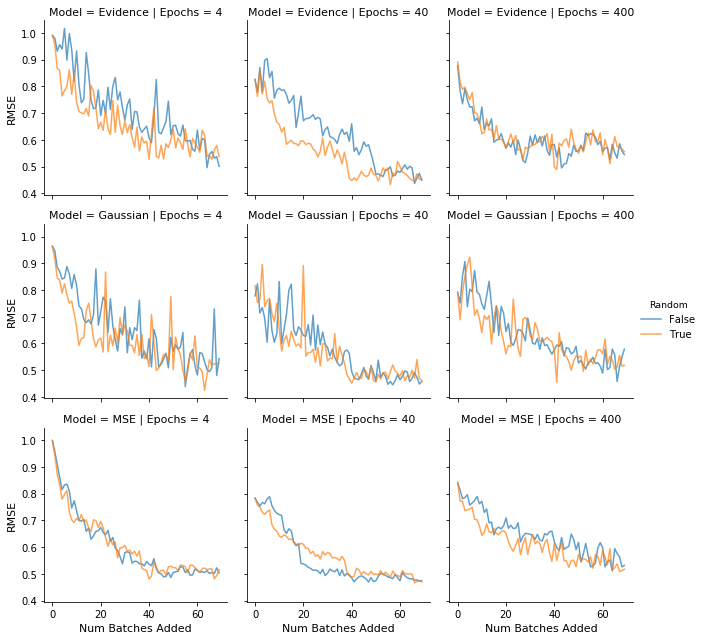

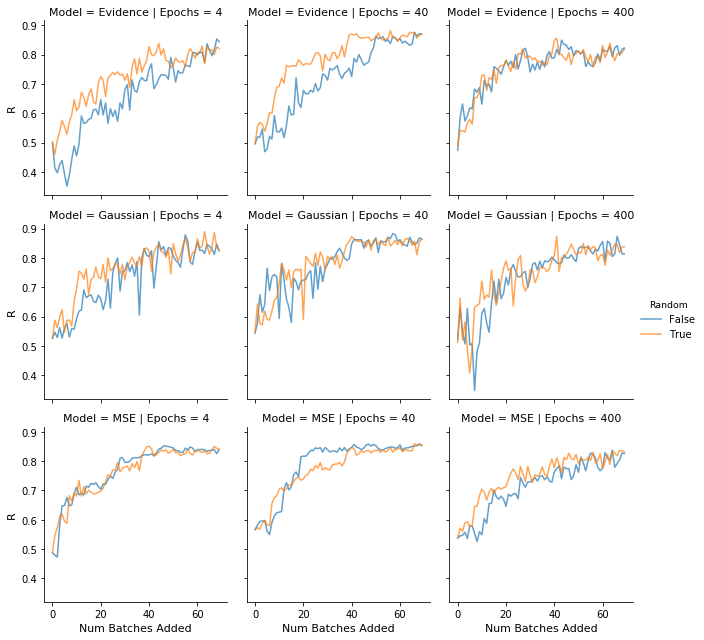

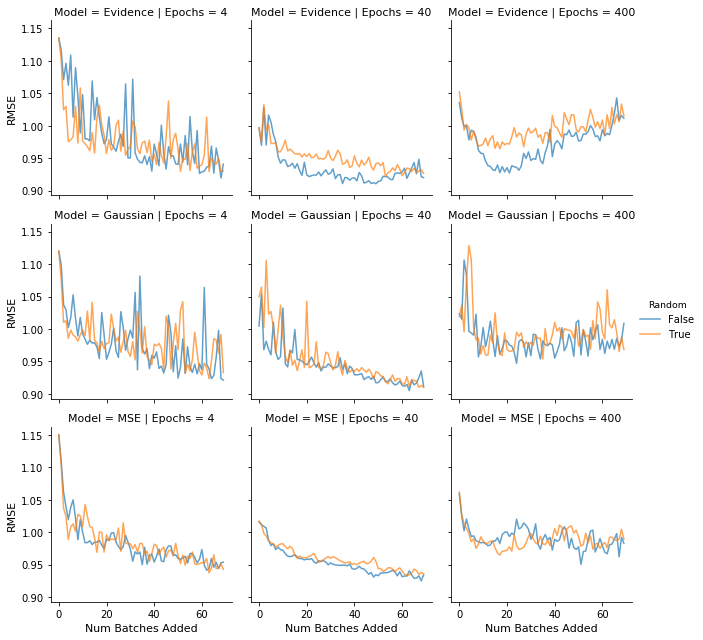

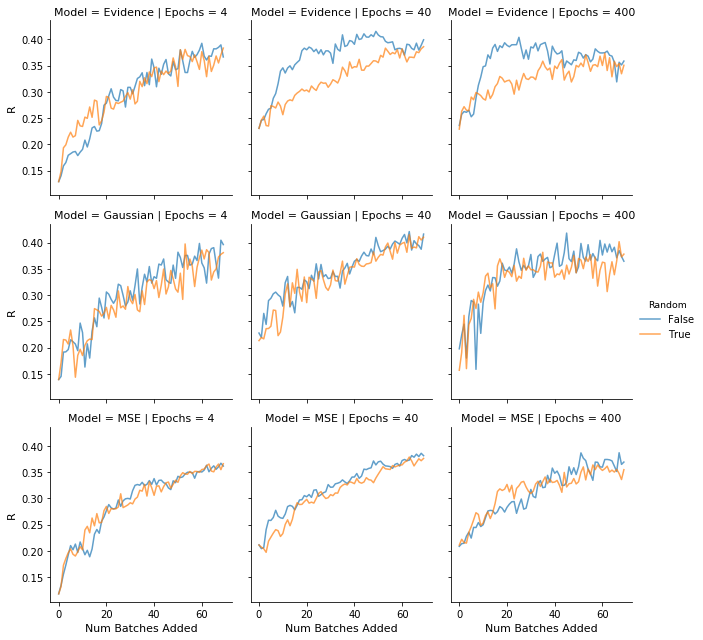

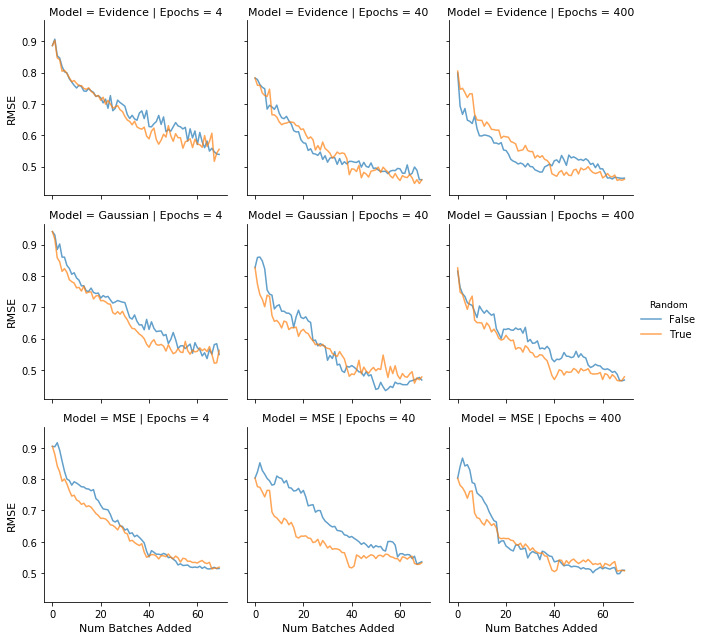

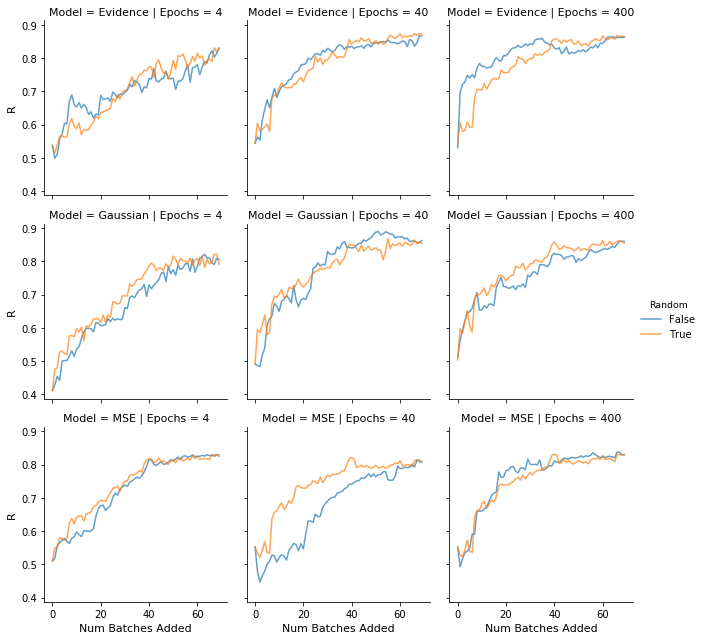

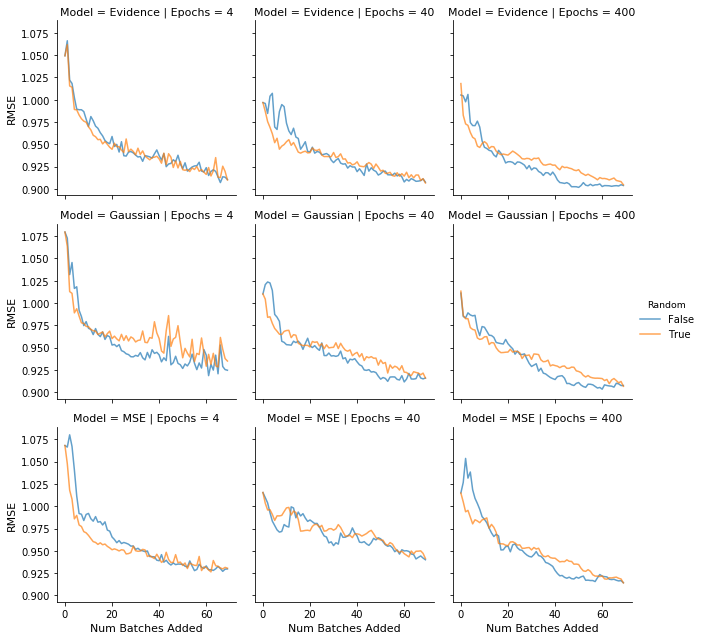

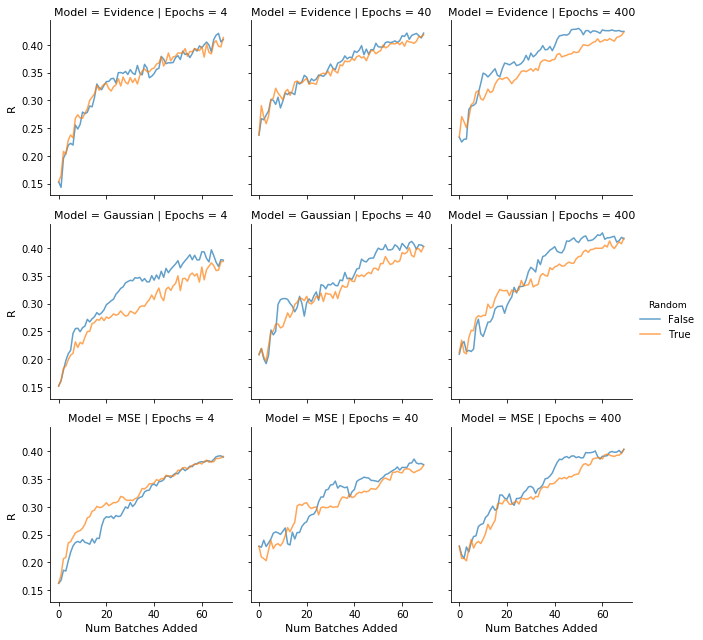

In [48]:
for key in ['nh9','bylabel']:
    df=pd.read_csv(f'results/fig10_morgan_fp_{key}_molbatch.csv')
    for yval in ['RMSE','R']:
        g=sns.FacetGrid(df,hue='Random',row='Model',col='Epochs')
        g.map(sns.lineplot,'Num Batches Added',yval,alpha=0.7)
        g.add_legend()
        plt.savefig(f'figures/fig10_morgan_{key}_molbatch_{yval}.pdf',bbox_inches='tight')
        
    df=pd.read_csv(f'results/fig10_morgan_fp_{key}_molbatch_rest.csv')
    for yval in ['RMSE','R']:
        g=sns.FacetGrid(df,hue='Random',row='Model',col='Epochs')
        g.map(sns.lineplot,'Num Batches Added',yval,alpha=0.7)
        g.add_legend()
        plt.savefig(f'figures/fig10_morgan_{key}_molbatch_rest_{yval}.pdf',bbox_inches='tight')